# GROUP ASSIGNMENT [COSC2753]

**Members**:
- Vo Thanh Luan – s3822042

In [38]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Preprocess image data
from PIL import Image
from pathlib import Path
import imageio.v2 as imageio
import imagehash
import glob

# Image reprocessing and image extraction
from tqdm import tqdm
import os
import cv2
import pickle
import datetime
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

# I. Problem statement



- Task 1: Classify images according to flower type (Baby, Calimero, Chrysanthemum, Hydrangeas, Lisianthus, Pingpong, Rosy and Tana).
- Task 2: Recommend 10 flower images in the dataset which is similar to the input flower image from users.

# 1. Data retrieving

In [ ]:
flower_dataset_directory = "data/Flowers/"
flower_category_foldername = os.listdir(flower_dataset_directory)
print(flower_category_foldername)

In [ ]:
link = []
for label in flower_category_foldername:
    path = os.path.join(flower_dataset_directory, label) # combine path and labels
    link.append(path) # append in link
print(link)

for i in range(len(link)):
    new = os.listdir(link[i])
    i+=1
    print(f"length : cd {len(new)}") # each folder total image count

In [39]:
IMAGE=[]
LABEL=[]
IMG_SIZE=200

def assign_label(img,flower_category):
    return flower_category

def make_train_data(flower_category,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_category)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        IMAGE.append(np.array(img))
        LABEL.append(str(label))

In [41]:
FLOWER_DIR = []
flower_categories = ["Babi", "Calimerio", "Chrysanthemum", "Hydrangeas", "Lisianthus", "Pingpong", "Rosy", "Tana"]

for category in flower_categories:
    flower_dir = f"data/Flowers/{category}"
    FLOWER_DIR.append(flower_dir)
    make_train_data(category, flower_dir)
print(len(IMAGE))

100%|██████████| 623/623 [00:00<00:00, 1054.43it/s]

4621


# 2. Explanatory Data Analysis

# 3. Data cleaning

## 3.1. Check image filetype

In [ ]:
def check_image_extensions(input_dir, allowed_extensions):
    # Initialize a dictionary to count the number of files of each type
    file_count = {extension: 0 for extension in allowed_extensions}
    # Loop over each flower category
    for category in os.listdir(input_dir):
        # Get the path to the category directory
        category_dir = os.path.join(input_dir, category)
        # Loop over each image file in the category directory
        for filename in os.listdir(category_dir):
            # Get the file extension of the image file
            extension = os.path.splitext(filename)[-1]
            # Check if the extension is allowed
            if extension in allowed_extensions:
                # Increment the file count for the extension
                file_count[extension] += 1
            else:
                print(f"Error: {filename} in {category} has invalid extension {extension}")
    # Calculate the total number of files
    total_files = sum(file_count.values())
    # Print the percentage of each file type
    for extension, count in file_count.items():
        percentage = count / total_files * 100
        print(f"{extension}: {percentage:.2f}%")

In [ ]:
allowed_extensions = {".jpg"}
check_image_extensions(flower_dataset_directory, allowed_extensions)

## 3.2. Detect corrupt image

It is crucial to detect corrupted images, as they can negatively impact the performance of a machine learning model or computer vision system. Images that have been corrupted may contain noise, artifacts, or other anomalies that can lead to misclassifications or output errors. Improve the accuracy and dependability of a model or system by detecting and removing these images from the dataset. In addition, corrupted images can cause biases in the model or system, which can lead to erroneous results or unjust decisions.

In [ ]:
corrupted_image = list()
accu = 0

for root, dirs, files in os.walk(flower_dataset_directory):
    for name in dirs:
        print(os.path.join(root, name))
        for image_file in Path(os.path.join(root, name)).glob('*.jpg'):
          accu = accu + 1
          try :
              image = imageio.imread(image_file)
            #   print(f'read {image_file}')
          except :
              print(f'Cannot read image {image_file}')
              corrupted_image.add(image_file)
print("Total number of images : ", accu)

In [ ]:
len(corrupted_image)

## 3.3. Image duplication detection

Duplicate image detection is essential for multiple reasons:

1. Reducing storage: Storing duplicate images wastes storage space, and detecting and removing them can help reduce storage costs.

2. Improving efficiency: Processing or analyzing duplicate images is inefficient and time-consuming. Removing duplicates can improve processing and analysis efficiency.

3. Enhancing accuracy: Duplicate images can bias the results of image-based analysis, such as object detection or image classification. Removing duplicates can improve the accuracy of these analyses.

4. Maintaining data integrity: Duplicates can lead to confusion and inconsistency in data, especially when dealing with large image datasets. Removing duplicates helps to maintain data integrity and consistency.

In [ ]:
# Define a function to compute the hash of an image file
def compute_hash(filepath):
    with Image.open(filepath) as img:
        return str(imagehash.phash(img))

def remove_duplicates(rootdir):
    hashes = {}
    duplicated = []
    rootdir = glob.glob(rootdir)
    for folder in rootdir:
        print()
        print(folder)
        for image_dir in glob.glob(folder+'/*.jpg'):
            # Compute the hash of the image file
            file_hash = compute_hash(image_dir)
            # Check if this hash has already been seen
            file=os.path.basename(image_dir).split('/')[-1]
            if file_hash in hashes:
                # This file is a duplicate, so remove it
                os.remove(image_dir)
                print(f'Removed duplicate file: {file}')
                duplicated.append(file)
            else:
                # This file is not a duplicate, so remember its hash
                hashes[file_hash] = file
        print(r'Duplicated image in ',folder,' :',len(duplicated))

remove_duplicates('./data/Flowers/*')

## 3.4. Check image resolution

In [43]:
for img in IMAGE:
    print(img.shape)


(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 

## 3.5. Check image color

## 3.6. Check outlier

In [31]:
from sklearn.neighbors import LocalOutlierFactor

def calculate_image_features(img_path):
    # Load the image and convert to grayscale
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the image's contrast and brightness
    min_gray = gray.min()
    max_gray = gray.max()
    contrast = (max_gray - min_gray) / max_gray
    brightness = gray.mean()
    
    # Return the image's features as a NumPy array
    return np.array([contrast, brightness])

def detect_outliers_in_category(category_path):
    # Calculate the features for each image in the category
    X = []
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        if os.path.isfile(file_path):
            features = calculate_image_features(file_path)
            X.append(features)
    X = np.array(X)
    
    # Detect outliers using the LOF algorithm
    clf = LocalOutlierFactor(n_neighbors=20)
    y_pred = clf.fit_predict(X)
    
    # Plot the LOF scores for each image
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='cool')
    plt.colorbar()
    plt.title(category_path)
    plt.xlabel('Contrast')
    plt.ylabel('Brightness')
    plt.show()

def detect_outliers_in_all_categories(root_path):
    for category_name in os.listdir(root_path):
        category_path = os.path.join(root_path, category_name)
        if os.path.isdir(category_path):
            detect_outliers_in_category(category_path)

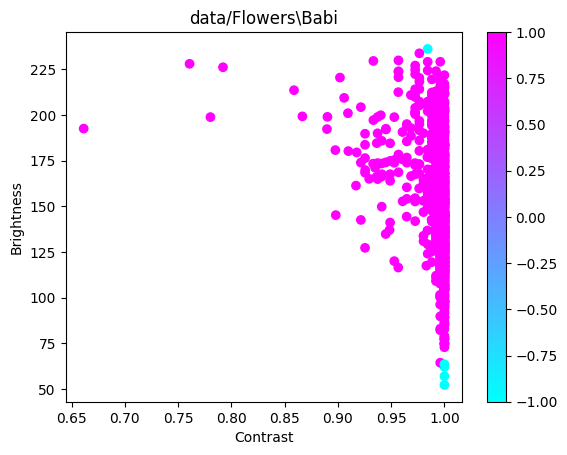

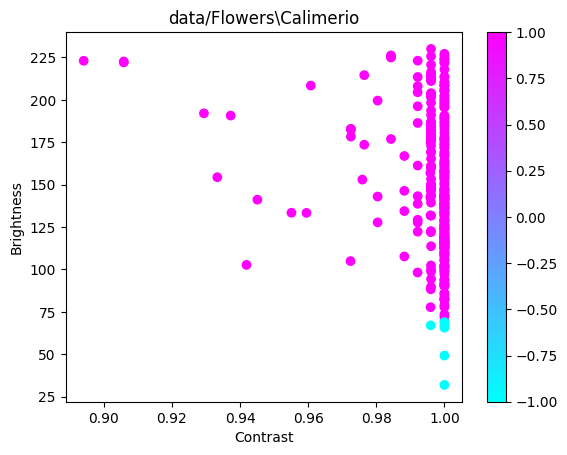

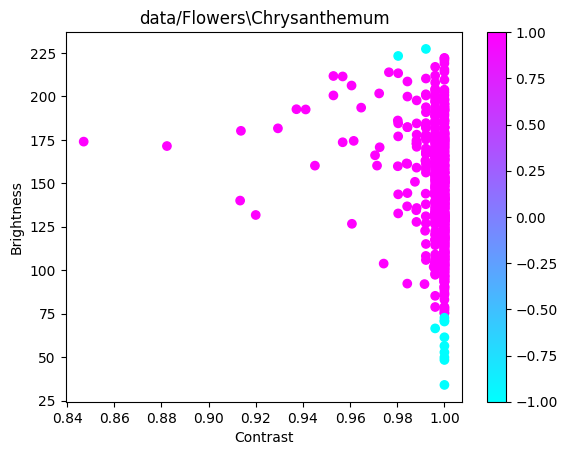

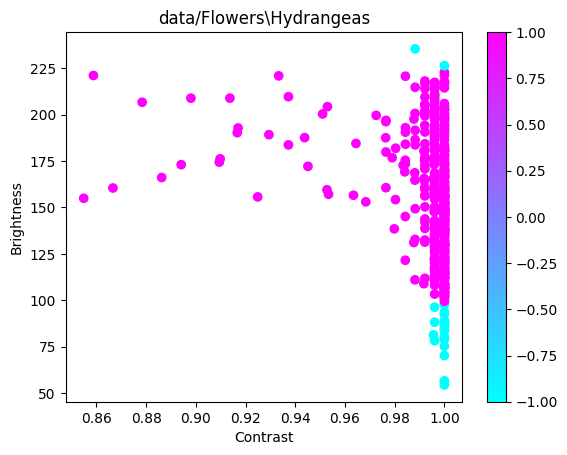

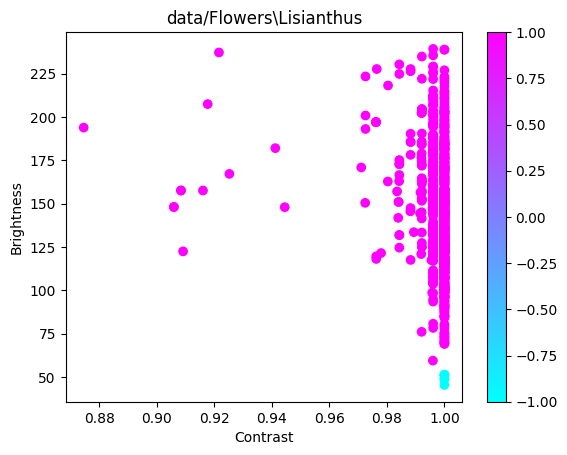

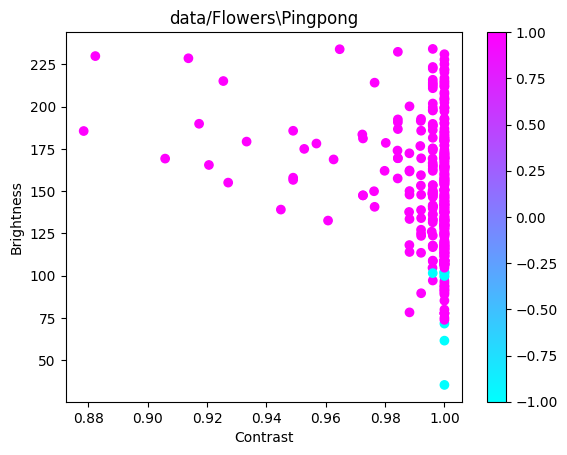

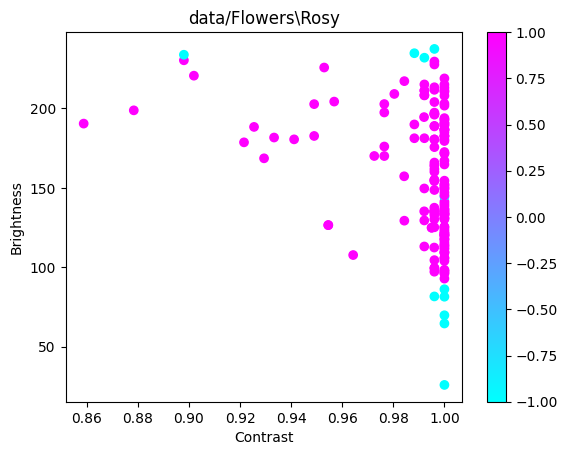

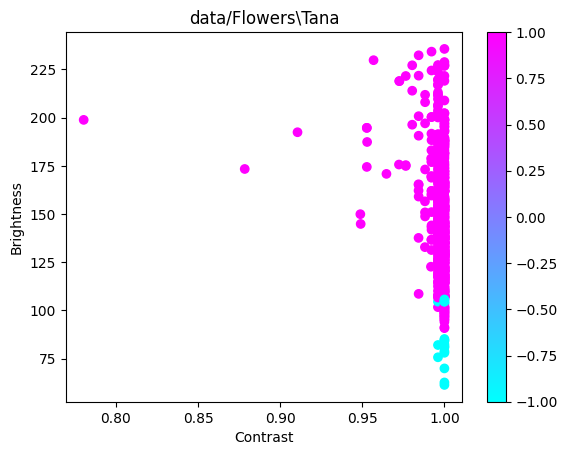

In [32]:
detect_outliers_in_all_categories('data/Flowers')

# Task 1: Classification

# Task 2: Recommender

### Feature engineering

Resnet50 For Feature Extraction

In [ ]:
# display a single image
def display_image(path):
    img = Image.open(path)
    display(img)

Recommender using ResNet50 Features

Recommender using VGG16 Features